In [1]:
import numpy as np
from PIL import Image
import os,glob
import pickle
import matplotlib.pyplot as plt
from IPython.display import display

class PCA:
    def __init__(self, folderName, size):
        self.folderName = folderName
        self.size = size
        self.samples = []
        self.fileNames = []
    
    def dataLoader(self):
        samples = []
        for filename in glob.glob(self.folderName+'\*.jpg'):
            path = os.path.join(os.getcwd(), filename)
            self.fileNames.append(filename[11:])
            img = Image.open(path).resize(self.size, Image.NEAREST)
            samples.append(np.array(img).reshape(self.size[0]*self.size[1],3))
        self.samples = np.array(samples)
    
    def saveSample(self):
        with open('imgArr.pickle', 'wb') as f:
            pickle.dump([self.fileNames, self.samples], f)

    def loadSample(self):
        with open('imgArr.pickle', 'rb') as f:
            self.fileNames, self.samples = pickle.load(f)

    def normalizeColors(self):
        self.colors = np.zeros((3,self.samples.shape[0],self.samples.shape[1]))
        self.meanList, self.stdList = [], []
        for i in range(3):
            color = self.samples[:,:,i].copy()
            meanC = color.mean(axis=1)
            color = color - meanC[:,None]
            stdC = np.reciprocal(color.std(axis=1))
            color = color*stdC[:,None]
            self.colors[i] = color
            self.meanList.append(meanC)
            self.stdList.append(stdC)

    def extractSVD(self):
        self.P, self.D, self.W = [[],[],[]], [[],[],[]], [[],[],[]]
        for k in range(3):
            color = self.colors[k].copy()
            _ , eigenvalues, eigenvectors = np.linalg.svd(color)
            self.D[k] = eigenvalues
            self.P[k] = eigenvectors.T
            self.W[k] = np.dot((color*np.reciprocal(self.stdList[k])[:,None]), eigenvectors.T)
    
    def saveSVD(self):
        with open('eigen.pickle', 'wb') as f:
            pickle.dump([self.P, self.D, self.W,], f)
    
    def loadSVD(self):
        with open('eigen.pickle', 'rb') as f:
            self.P, self.D, self.W = pickle.load(f)
    
    def plotScree(self, pcaCount):
        prop_varL = np.zeros((3, pcaCount))
        cum_varL = np.zeros((3, pcaCount))
        colors = ["red", "green", "blue"]
        sizes = [4,3,2]
        x_labels = ['PC{}'.format(k+1) for k in range(pcaCount)]
        for i in range(3):
            eigenvalues = self.D[i]
            sum_eigenvalues = np.sum(eigenvalues)
            prop_varL[i] = [k/sum_eigenvalues for k in eigenvalues[:pcaCount]]
            cum_varL[i] = [np.sum(prop_varL[i][:k+1]) for k in range(pcaCount)]
            plt.plot(x_labels, prop_varL[i], marker='o', markersize=sizes[i]+2, color=colors[i], linewidth=sizes[i], label='Proportion of variance for color '+ colors[i])
            plt.plot(x_labels, cum_varL[i], marker='o', markersize=sizes[i]+2, color='dark'+colors[i], linewidth=sizes[i], label="Cumulative variance for color "+colors[i])
        plt.legend()
        plt.title('Scree plot')
        plt.xlabel('Principal components')
        plt.ylabel('Proportion of variance')
        plt.show()
        return prop_varL, cum_varL
    
    def showEigenFace(self, idx):
        meanNp = np.mean(np.array(self.meanList), axis = 1)
        stanDev = np.mean(np.array(np.reciprocal(self.stdList)), axis = 1)
        eigenface = np.moveaxis(np.array(self.P),-1,0)[idx].T
        eigenface = eigenface*stanDev**2 + meanNp
        eigenface = np.round(eigenface).astype(int).tolist()
        eigenface = [tuple(row) for row in eigenface]
        img = Image.new("RGB", self.size)
        img.putdata(eigenface)
        display(img)
    
    def reconstructSample(self, fileName, npcs):
        idx = self.fileNames.index(fileName)
        meanNp = np.array(self.meanList)[:,idx]
        sampleConstruct = []
        for i in range(3):
            colorMap = np.dot(self.W[i][idx,:npcs], self.P[i][:,:npcs].T)
            sampleConstruct.append(colorMap+meanNp[i])
        sampleConstruct = np.array(sampleConstruct, dtype = int).T
        sampleConstruct = [tuple(row) for row in sampleConstruct]
        img = Image.new("RGB", self.size)
        img.putdata(sampleConstruct)
        display(img)
        return sampleConstruct

In [2]:
#Edit these values if necessary
relative_path = 'crop_part1' # the relative path to the folder that includes all files to be processed
resolution = (64,64)         # desired resolution

In [ ]:
#Quick Load - Do not use if saves are not present
UTK = PCA(relative_path, resolution)
UTK.loadSample()
UTK.normalizeColors()
UTK.loadSVD()

In [3]:
#instance initialization
UTK = PCA(relative_path, resolution)

In [4]:
#loads the data, processes it into ndarrays
UTK.dataLoader()
#normalizes and seperates color channels
UTK.normalizeColors()

In [ ]:
#creates eigenvalues, eigenvectors and weights for reconstruction
UTK.extractSVD()

In [9]:
#Saves the extracted samples and SVD matrices as pickle files to the current directory
UTK.saveSample()
UTK.saveSVD()

In [10]:
#scree plot for the first -10- principal components
%matplotlib qt
#%matplotlib inline
prop_var, cum_var = UTK.plotScree(10)

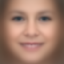

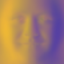

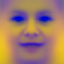

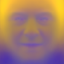

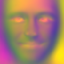

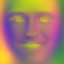

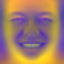

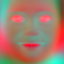

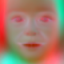

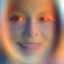

In [7]:
#shows the first -10- eigenfaces
for face in range(10):
    UTK.showEigenFace(face)

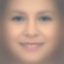

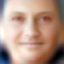

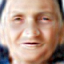

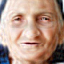

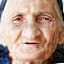

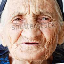

In [8]:
#reconstruct the given file for different PCs
for vectorCount in [1, 50, 250, 500, 1000, 4096]:
    reconstruct = UTK.reconstructSample("100_1_0_20170110183726390.jpg.chip.jpg", vectorCount)